# "Monte Carlo Methods 2"
> "In this blog post we continue to look at Monte Carlo methods and how they can be used. We move from sampling from univariate distributions to multi-variate distributions."
- toc: true
- author: Lewis Cole (2020)
- branch: master
- badges: false
- comments: false
- categories: [Monte-Carlo, Statistics, Probability, Computational-Statistics, Theory, Computation, Copula]
- hide: false
- search_exclude: false
- image: https://github.com/lewiscoleblog/blog/raw/master/images/Monte-Carlo/copula.png

___
This is the second blog post in a series - you can find the previous blog post [here](https://lewiscoleblog.com/monte-carlo-methods)
___

In this blog post we shall continue our exploration of Monte Carlo methods. To briefly recap in the previous blog post we looked at the general principle underlying Monte-Carlo methods, we looked at methods used by pseudo-random number generators to feed our models and we looked at a variety of methods to convert these uniform variates to general univariate distributions.

## Multi-Variate Relations
We start by looking at the problem of sampling from general multi-variate distributions. In many instances simply sampling univariate distributions will be insufficient. For example if we are creating a model that looks of mortgage repayment defaults we do not want to model the default rate by one univariate distribution and the interest rate by another univariate distribution using the techniques described so far. In an ideal world we would know the exact relationship we are trying to model, in physics and the hard sciences the exact mechanism underlying the joint behaviour may be modelled exactly. However in many cases in finance (and the social sciences) this is very hard to elicit (if not impossible) so we want to create "correlated" samples that capture (at least qualitatively) some of the joint behaviour.

### Measures of Correlation
We start by looking at some measures of dependance between variables. This helps us evaluate whether a model is working as we would expect or not. A lot of times joint-dependence is difficult to elicit from the data so often with this sort of model there is a lot of expert judgements, sensitivity testing, back testing and so on in order to calibrate a model. This is out of the scope of what I'm looking to cover in this blog post series but is worth keeping in mind for this section on multi-variate methods.

By far the most prevelant measure of dependance is the Pearson correlation coefficient. This is the first (and in many cases only) measure of depedence we find in textbooks. We can express it algebraically as:
$$ \rho_{(X,Y)} = \frac{\mathbb{E}[(X - \mathbb{E}(X))(Y - \mathbb{E}(Y))]}{\sqrt{\mathbb{E}[(X - \mathbb{E}(X))^2]\mathbb{E}[(Y - \mathbb{E}(Y))^2]}} = \frac{Cov(X,Y)}{SD(X)SD(Y)}$$

That is the ratio of the covariance between two variables divide by the product of their standard deviations. This measure has a number of useful properties - it gives a metric between $[-1,1]$ (via the Cauchy-Schwarz inequality) which varies from "completely anti-dependant" to "completely-dependant". It is also mathematically very tractable, it is very easy to calculate and it often crops up when performing an analytic investigation. However it's use in "the real world" is fairly limited, it is perhaps the most abused of all statistics.

One issue with this measure in practice is that it requires defined first and second moments for the definition to work. We can calculate this statistic on samples from any distribution, however if we are in the realms of fat-tailed distributions (such as a power-law) this sample estimate will be meaningless. In finance and real-world risk applications this is a big concern, it means that many of the early risk management models still being used that do not allow for the possiblity of fat-tails are at best not-useful and at worst highly dangerous for breeding false confidence.

Another issue with the measure is it is highly unintuitive. Given the way it is defined the difference between $\rho=0.05$ and $\rho = 0.1$ is negligible, yet the difference between $\rho = 0.94$ and $\rho = 0.99$ is hugely significant. In this authors experience even very "technical" practitioners fail to remember this and treat a "5% point increase" as having a consistent impact. This issue is compounded further when dealing with subject matter experts who do not necessarily have mathematical/probability training but have an "intuitive" grasp of "correlation"!

The biggest and most limiting factor for the Pearson coefficient however is that it only considers linear relationships between variables - any relation that is not linear will effectively be approximated linearly. In probability distribution terms this is equivalent to a joint-normal distribution. That is to say: **Pearson correlation only exhibits good properties in relation to joint-normal behaviour!**

Another option to use is the Spearmann correlation coefficient. This is strongly related to the Pearson correlation coefficient but with one important difference: instead of using the values themselves we work with the percentiles instead. For example suppose we have a standard normal distribution and we sample the point: $x = 1.64...$ we know that this is the 95th percentile of the standard normal CDF so we would use the value: $y=0.95$ in the definition of Pearson correlation above. This has the benefit that it doesn't matter what distributions we use we will still end up with a reasonable metric of dependance. In the case of joint-normality we will have that the Pearson and Spearmann coefficients are equal - this shows that Spearmann is in some sense a generalization of the Pearson.

However before we get too excited the issues around it being an unintuitive metric still stands. It also has the added complication that if we observe data "in the wild" we don't know what the percentile of our observation is! For example suppose we're looking at relationships between height and weight in a population: if we find a person of height: $1.75m$ what percentile does this correspond to? We will likely have to estimate this given our observations which adds a layer of approximation. In the case of heavy-tail distributions this is particularly problematic since everything may appear to be "normal" for many many observations but suddenly 1 extreme value will totally change our perception of the underlying distribution.

Another issue is that while the Spearmann doesn't rely only on linear relations - it does require at least monotone relations. Anything more complicated that that and the relationship will not be captured. Let's look at a few simple examples to highlight the differences between these metrics:

In [8]:
#hide
import warnings
warnings.filterwarnings('ignore')

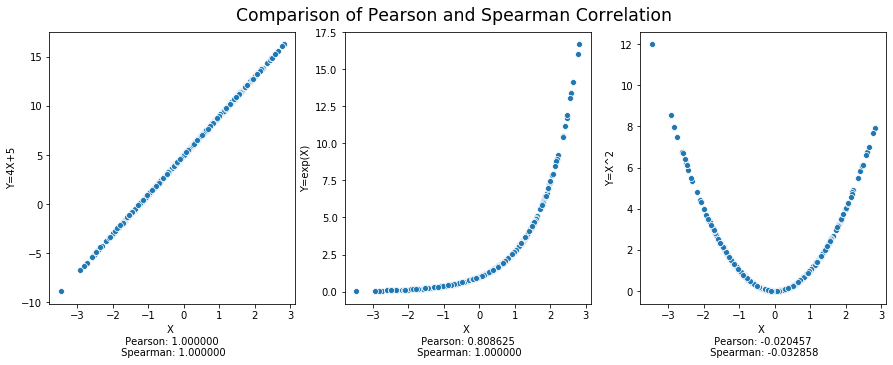

In [4]:
# Examples of Pearson and Spearman coefficients

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, rankdata, pearsonr
import seaborn as sns
%matplotlib inline

U = np.random.random(1000)
X = norm.ppf(U)
Y_lin = 4*X + 5
Y_exp = np.exp(X)
Y_con = X**2

# Create function to return estimated percentile
def pctile(x):
    return rankdata(x) / x.shape[0]

# Calculate Pearson coefficients
pea_lin = pearsonr(X, Y_lin)[0]
pea_exp = pearsonr(X, Y_exp)[0]
pea_con = pearsonr(X, Y_con)[0]

# Calculate Spearman coefficients
X_pct = pctile(X)
Y_lin_pct = pctile(Y_lin)
Y_exp_pct = pctile(Y_exp)
Y_con_pct = pctile(Y_con)

spe_lin = pearsonr(X_pct, Y_lin_pct)[0]
spe_exp = pearsonr(X_pct, Y_exp_pct)[0]
spe_con = pearsonr(X_pct, Y_con_pct)[0]

# Create Plots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(X, Y_lin, ax=ax[0])
ax[0].set_ylabel("Y=4X+5")
ax[0].set_xlabel("X \n Pearson: %f \n Spearman: %f" %(pea_lin, spe_lin))
sns.scatterplot(X, Y_exp, ax=ax[1])
ax[1].set_ylabel("Y=exp(X)")
ax[1].set_xlabel("X \n Pearson: %f \n Spearman: %f" %(pea_exp, spe_exp))
sns.scatterplot(X, Y_con, ax=ax[2])
ax[2].set_ylabel("Y=X^2")
ax[2].set_xlabel("X \n Pearson: %f \n Spearman: %f" %(pea_con, spe_con))
fig.suptitle("Comparison of Pearson and Spearman Correlation", x=0.5, y=0.95, size='xx-large')
plt.show()


We can see here that for a linear translation both metrics produce the same result. In the case of a non-linear monotone (e.g. exponential) relation the Spearman correctly identifies full dependancy. However neither metric is capable of capturing the dependency in the last non-monotone example - in fact both metrics suggest independence! From a basic visual inspection we would not describe these two variables as being independent. This shows we need to be careful using correlation metrics such as these. This is even before the introduction of noise!

Another somewhat popular choice of dependancy metric is the Kendall-Tau metric. This is a little different to the preceeding options. Essentially to calculate the Kendall-Tau we look at the joint pairs of samples, if both are concordant we add $1$ to a counter otherwise add $-1$ and move onto the next pair. We then take the average value of this (i.e. divide by the total number of pairs of joint samples). We can equally denote this by the formula:
$$  \tau ={\frac {2}{n(n-1)}}\sum _{i<j}\operatorname{sgn}(x_{i}-x_{j})\operatorname{sgn}(y_{i}-y_{j})$$

Where $\operatorname{sgn}(.)$ is the sign operator. $x_i$ and $y_i$ represent the rank or percentile of each sample within the set of all $x$ or $y$ samples. The benefit of the Kendall-tau is it is slightly more intuitive than the Spearman however it still suffers from some of the same issues (e.g. it will fail the $X^2$ example above). 

We can show that Pearson, Spearman and Kendall are both particular cases of the generalized correlation coefficient:
$$\Gamma ={\frac  {\sum _{{i,j=1}}^{n}a_{{ij}}b_{{ij}}}{{\sqrt  {\sum _{{i,j=1}}^{n}a_{{ij}}^{2}\sum _{{i,j=1}}^{n}b_{{ij}}^{2}}}}}$$

Where $a_{ij}$ is the x-score and $b_{ij}$ the y-score for pairs of samples $(x_i, y_i)$ and $(x_j, y_j)$. 

For example for the Kendall Tau we set: $a_{ij} = \operatorname{sgn}(x_i - x_j)$ and $b_{ij} = \operatorname{sgn}(y_i - y_j)$. For Spearman we set: $a_{ij} = (x_i - x_j)$ and $b_{ij} =(y_i - y_j)$. Where again we are working with ranks (or percentiles) rather than sampled values themselves.

Can we improve on these metrics from a practical standpoint? The answer is: yes! Unfortunately it is difficult to do and there is as much art as there is science to implementing it. We instead consider the mutual-information:
$$I(X, Y) = \int \int p_{X,Y}(x,y) \operatorname{log}\left( \frac{p_{X,Y}(x,y)}{p_X(x)p_Y(y)} \right) dx dy $$

Or similar for discrete distributions. Here $p_{X,Y}(.)$ represents the joint pdf of $(X,Y)$ and $p_X$, $p_Y$ represent the marginal distributions of $X$ and $Y$ respectively. This has the interpretation that it represents the information gained in knowing about the joint distribution compared to assuming independance of the marginal distributions. This is essentially matches our intuition of what dependance "is". However it is a bit of a pain to work with since we usually have to make distributional assumptions. 

We can use generalizations of mutual information also. For example total correlation:
$$C(X_{1},X_{2},\ldots ,X_{n})=\left[\sum _{{i=1}}^{n}H(X_{i})\right]-H(X_{1},X_{2},\ldots ,X_{n}) $$

Which is the sum of information for each marginal distribution less the joint information. This compares to mutual information that can be expressed:
$$ \operatorname{I} (X;Y)=\mathrm {H} (Y)-\mathrm {H} (Y|X) $$

Another possible generalization to use is that of dual-total correlation which we can express as:
$$D(X_{1},\ldots ,X_{n})=H\left(X_{1},\ldots ,X_{n}\right)-\sum _{i=1}^{n}H\left(X_{i}\mid X_{1},\ldots ,X_{i-1},X_{i+1},\ldots ,X_{n}\right) $$

In the above we use the functional $H(.)$ to represent information:
$$H=-\sum _{i}p_{i}\log _{2}(p_{i}) $$

Or similar for continuous variables.

Despite the complications in working with these definitions these functions do pass the "complicated" examples such as $Y=X^2$ above and are a much better match for our intuition around dependence. I have long pushed for these metrics to be used more widely.


### Other Measurements of Dependence
We now appreciate that there are many different ways in which random variables can relate to each other (linear, monotone, independent, and so on.) So far the metrics and measures presented are "overall" measures of dependence, they give us one number for how the variables relate to each other. However in many cases we know that relations are not defined by just one number - typically we may find stronger relations in the tails (in extreme cases) than in "everyday" events. In the extreme we may have independence most of the time and yet near complete depednence when things "go bad". For an example of this consider we are looking at property damage and one factor we consider is wind-speed. At every day levels of wind there is unlikely to be much of a relationship between wind-speed and property damage - any damage that occurs is likely to be due to some other cause (vandalism, derelict/collapsing buildings, and so on). However as the wind-speed increases at a certain point there will be some property damage caused by the wind. At more extreme levels (say at the hurricane level) there will be almost complete dependence between wind level and property damage level. It is not difficult to think of other examples. In fact you'll likely find that most relations display this character to some degree often as a result of a structural shift in the system (e.g. in the wind example through bits of debris flying through the air!) Of course we would like to model these structural shifts exactly but this is often complicated if not impossible - through Monte-Carlo methods we are able to generate samples with behaviour that is at least qualitatively "correct".

We call this quality "tail dependence". This can affect upside and downside tails or just one tail depending on the phenomena. 

Naively we would think that an option would be to use one of the correlation metrics above on censored data (that is filtering out all samples below/above a certain threshold). Unfortunately this does not work, the correlation metric is not additive - meaning you can't discretize the space into smaller units and combine them to give the overall correlation measure. This is another reason correlation metrics don't fit well with our intuition. However the information theoretic quantities can satisfy this condition but as before are a little more difficult to work with. We have some specialist metrics that are easier to use for this purpose.

The simplest metric to look at to study tail-dependence is the "joint exceedance probability". As the name suggests we look at the probability of time that the joint distribution exists beyond a certain level (or below a certain level). Suppose we have joint observations $(X_i, Y_i)_{i=1}^N$ and we have: $\mathbb{P}(X > \tilde{x}) = p$ and $\mathbb{P}(Y > \tilde{y}) = p$ then the joint exceedance probability of $(X,Y)$ at percentile $p$ is:
$$JEP_{(X,Y)}(p) = \frac{\sum_i\mathbb{1}_{(X_i > \tilde{x})}\mathbb{1}_{(Y_i > \tilde{y}})}{N} $$

Where: $\mathbb{1}_{(.)}$ is the indicator variable/Heaviside function. By construction we have that for $X$ and $Y$ fully rank-dependent then $JEP_{(X,Y)}(p) = p$ if $X$ and $Y$ fully rank-independent then $JEP_{(X,Y)}(p) = p^2$. It often helps to standardise the metric to vary between $[0,1]$ through the transform (we wouldn't use this metric if we are in the case of negative-dependence so can limit ourselves to indpendence as the lower-bound):
$$JEP_{(X,Y)}(p) = \frac{\sum_i\mathbb{1}_{(X_i > \tilde{x})}\mathbb{1}_{(Y_i > \tilde{y}})}{pN} - p$$

As with other rank-methods this metric is only useful with monotone relations, it cannot cope with non-monotone relations such as the $Y=X^2$ example.

We can also view tail dependence through the prism of probability theory. We can define the upper tail dependence ($\lambda _{u}$) between variables $X_1$ and $X_2$ with CDFs $F_1(.)$ and $F_2(.)$ respectively as:
$$\lambda _{u}=\lim _{q\rightarrow 1}\mathbb{P} (X_{2}>F_{2}^{-1}(q)\mid X_{1}>F_{1}^{-1}(q))$$

The lower tail dependence ($\lambda _{l}$) can be defined similarly through:
$$\lambda _{l}=\lim _{q\rightarrow 0}\mathbb{P} (X_{2}\leq F_{2}^{-1}(q)\mid X_{1} \leq F_{1}^{-1}(q))$$

The JEP metric above is in some sense a point estimate of these quantities, if we had infinite data and could make $p$ arbitrarily small in $JEP_{(X,Y)}(p)$ we would tend to $\lambda _{u}$. We will revisit the tail-dependence metric once we have built up some of the theoretical background.

## Multi-Variate Generation
We now move onto the issue of generating multi-variate samples for use within our Monte-Carlo models. It is not always to encode exact mechanisms for how variables relate (e.g. if we randomly sample from a distribution to give a country's GDP how do we write down a function to turn this into samples of the country's imports/exports? It is unlikely we'll be able to do this with any accuracy, and if we could create functions like this we would better spend our time speculating on the markets than developing Monte-Carlo models!) So we have to rely on broad-brush methods that are at least qualitatively correct.

### Multi-Variate Normal
We start with perhaps the simplest and most common joint-distribution (rightly or wrongly) the multi-variate normal. As the name suggests this is a multi-variate distribution with normal distributions as marginals. The joint behaviour is specified by a covariance matrix ($\mathbf{\Sigma}$) representing pairwise covariances between the marginal distributions. We can then specify the pdf as:
$$f_{\mathbf {X} }(x_{1},\ldots ,x_{k})={\frac {\exp \left(-{\frac {1}{2}}({\mathbf {x} }-{\boldsymbol {\mu }})^{\mathrm {T} }{\boldsymbol {\Sigma }}^{-1}({\mathbf {x} }-{\boldsymbol {\mu }})\right)}{\sqrt {(2\pi )^{k}|{\boldsymbol {\Sigma }}|}}}$$

Which is essentially just the pdf of a univariate normal distribution just with vectors replacing the single argument. To avoid degeneracy we require that $\mathbf{\Sigma}$ is a positive definite matrix. That is for any vector $\mathbf{x} \in \mathbb{R}^N_{/0}$ we have: $\mathbf{x}^T \mathbf{\Sigma} \mathbf{x} > 0$.

How can we sample from this joint distribution? One of the most common was is through the use of a matrix $\mathbf{A}$ such that: $\mathbf{A} \mathbf{A}^T = \mathbf{\Sigma}$. If we have a vector of independent standard normal variates: $\mathbf{Z} = (Z_1, Z_2, ... , Z_N)$ then the vector: $\mathbf{X} = \mathbf{\mu} + \mathbf{A}\mathbf{Z}$ follows a multivariate normal distribution with means $\mathbf{\mu}$ and covariances $\mathbf{\Sigma}$. The Cholesky-decomposition is typically used to find a matrix $\mathbf{A}$ of the correct form, as a result I have heard it called the "Cholesky-method". We will not cover the Cholesky decomposition here since it is a little out of scope, you can read more about it [here](https://en.wikipedia.org/wiki/Cholesky_decomposition) if you would like.

Let's look at an example of generating a 4d multivariate normal using this method:

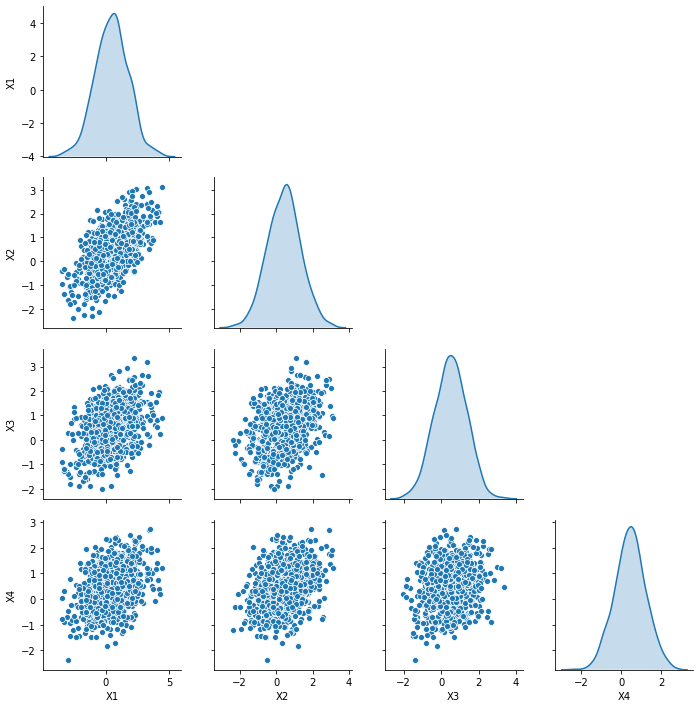

In [24]:
# Simulating from a multivariate normal
# Using Cholesky Decomposition

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

# Fix number of variables and number simulations
N = 4
sims = 1000

# Fix means of normal variates
mu = np.ones(N)*0.5

# Initialize covariance matrix
cov = np.zeros((N, N))

# Create a covariance matrix
# Randomly sampled
for i in range(N):
    for j in range(N):
        if i==j:
            cov[i, j] = 1
        else:
            cov[i, j] = 0.5
            cov[j, i] = cov[i, j]

# Calculate cholesky decomposition
A = np.linalg.cholesky(cov)

# Sample independent normal variates
Z = norm.rvs(0,1, size=(sims, N))

# Convert to correlated normal variables
X = Z @ A + mu

# Convert X to dataframe for plotting
dfx = pd.DataFrame(X, columns=["X1", "X2", "X3", "X4"])

# Create variable Plots
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)
    
pp = sns.pairplot(dfx, diag_kind="kde")
pp.map_upper(hide_current_axis)
plt.show()

Here we can see we have geerated correlated normal variates.

We see here that this is a quick and efficient way of generating correlated normal variates. However it is not without its problems. Most notably is specifying a covariance/correlation matrix quickly becomes a pain as we increase the number of variates. For example if we had $100$ variables we would need to specify: $4950$ coefficients (all the lower off diagonals). If we have to worry about the matrix being positive definite this quickly becomes a pain and we can even begin to run into memory headaches when matrix multiplying with huge matrices.

An alternative highly pragmatric approach is to use a "driver" approach. Here we keep a number of standard normal variables that "drive" our target variables - each target variable has an associated weight to each of the driver variables and a "residual" component for its idiosyncratic stochasticity. In large scale models this can drastically reduce the number of variables to calibrate. Of course we lose some of the explanatory power in the model, but in most cases we can still capture the behaviour we would like. This procedure in some sense "naturally" meets the positive definite criteria and we do not need to think about it. Let's look at this in action:

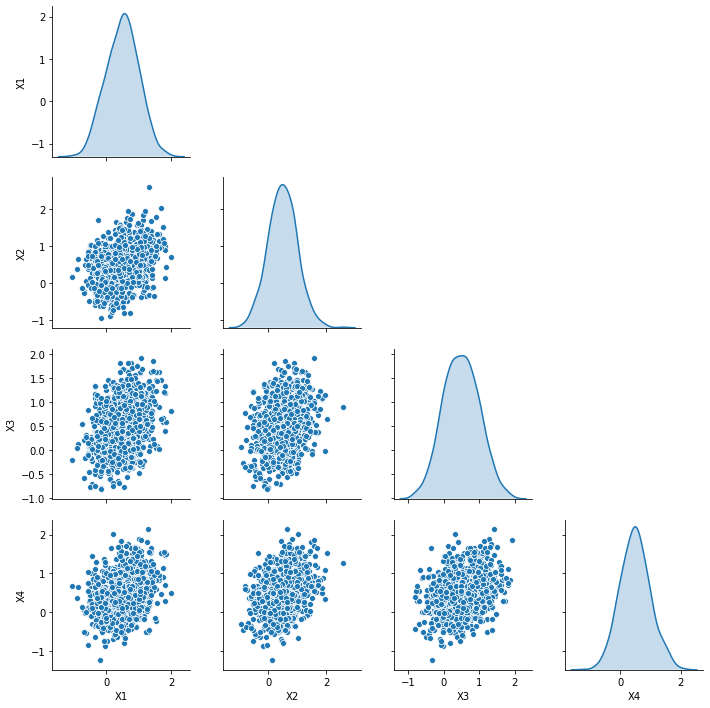

In [23]:
# Simulating from a multivariate normal
# Using a driver method

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Fix number of variables and number simulations
N = 4
sims = 1000

# Target means and standard deviations
mu = np.ones(N)*0.5
sig = np.ones(N)*0.5

# Fix number of driver variables
M = 2

# Specify driver weight matrix
w_mat = np.zeros((M, N))

for i in range(M):
    for j in range(N):
        w_mat[i, j] = 0.25


# Residual weights
w_res = 1 - w_mat.sum(axis=0)
        
# Simulate driver variables
drv =  norm.rvs(0,1, size=(sims, M))

# Simulate residual variables
res = norm.rvs(0,1, size=(sims, N))

# Calculate correlated variables
X = drv @ w_mat + w_res * res

# Standardise variables
X = (X - X.mean(axis=0)) / (X.std(axis=0))

# Apply transforms
X = X*sig + mu

# Convert X to dataframe for plotting
dfx = pd.DataFrame(X, columns=["X1", "X2", "X3", "X4"])

# Create variable Plots
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)
    
pp = sns.pairplot(dfx, diag_kind="kde")
pp.map_upper(hide_current_axis)
plt.show()

We can see that this "driver" method can significanlty reduce the number of parameters needed for our models. They can also be used to help "interpret" the model - for example we could interpret one of our "driver" variables as being a country's GDP we could then use this to study what happens to our model when GDP falls (e.g. is below the 25th percentile). The nature of the drivers is such that we do not need to know how to model them exactly, this is useful for modelling things such as "consumer sentiment" where a sophisticated model does not necessarily exist. This is part of the "art" side of Monte-Carlo modelling rather than a hard science.

The tail dependence parameters from the multi-variate normal satisfy:
$$\lambda_u = \lambda_l = 0$$

That is there is no tail-dependence. This can be a problem for our modelling.

### Other Multivariate Distributions
With the multivariate normal under our belts we may now want to move onto other joint distributions. Unfortunately things are not that simple, using the methods above we are essentially limited to multivariate distributions that can be easily built off of the multivariate normal distribution. One such popular example is the multivariate student-t distribution. We can sample from this using the transform:
$$ \mathbf{X} = \frac{\mathbf{Z}}{\sqrt{\frac{\chi_{\nu}}{\nu}}}$$

Where: $\mathbf{Z}$ is a multivariate normal and $\chi_{\nu}$ is a univariate chi-square with $\nu$ degrees of freedom. The resulting multivariate student-t has covariance matrix $\mathbf{\Sigma}$ and $\nu$ degrees of freedom. Here the degrees of freedom is a parameter that controls the degree of tail-dependence with lower values representing more tail dependence. In the limit $\nu \to \infty$ we have $\mathbf{X} \to \mathbf{Z}$.

We can add a couple of extra lines to our Gausssian examples above to convert them to a multi-variate student t distribution:

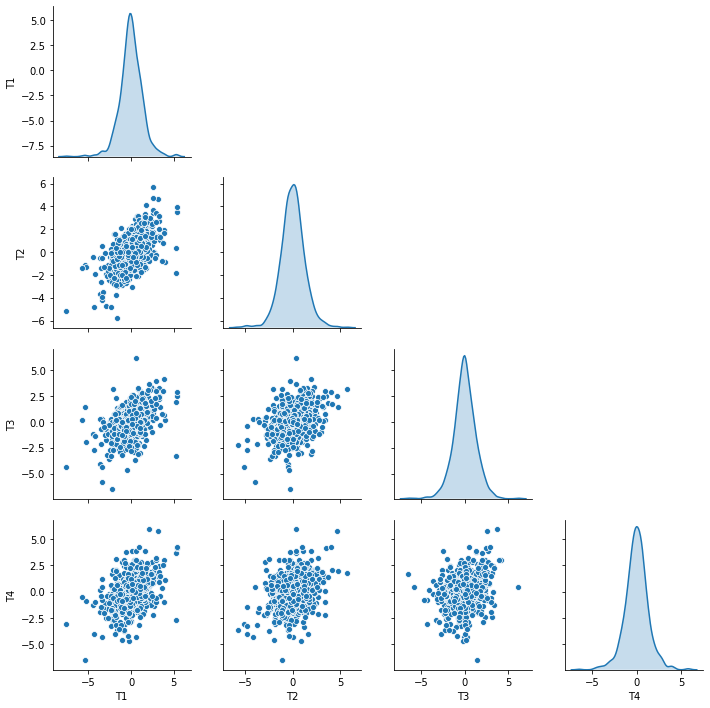

In [37]:
# Simulating from a multivariate student t
# Using Cholesky Decomposition and a chi2 transform

import numpy as np
from scipy.stats import norm, chi2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

# Fix number of variables and number simulations
N = 4
sims = 1000

# Fix means of normal variates
mu = np.ones(N)*0.5

# Initialize covariance matrix
cov = np.zeros((N, N))

# Set degrees of freedom nu
nu = 5

# Create a covariance matrix
# Randomly sampled
for i in range(N):
    for j in range(N):
        if i==j:
            cov[i, j] = 1
        else:
            cov[i, j] = 0.5
            cov[j, i] = cov[i, j]

# Calculate cholesky decomposition
A = np.linalg.cholesky(cov)

# Sample independent normal variates
Z = norm.rvs(0,1, size=(sims, N))

# Convert to correlated normal variables
X = Z @ A + mu

# Standardize the normal variates
Z = (X - X.mean(axis=0)) / X.std(axis=0)

# Sample from Chi2 distribution with nu degrees of freedom
chis = chi2.rvs(nu, size=sims)

# Convert standard normals to student-t variables
T = (Z.T / np.sqrt(chis / nu)).T

# Convert T to dataframe for plotting
dft = pd.DataFrame(T, columns=["T1", "T2", "T3", "T4"])

# Create variable Plots
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)
    
pp = sns.pairplot(dft, diag_kind="kde")
pp.map_upper(hide_current_axis)
plt.show()

The tail dependence parameter fro the student-t copula for 2 variates with correlation parameter $\rho$ and $\nu$ degrees of freedom is:

$$\lambda_u = \lambda_l = 2 t_{\nu+1} \left(- \frac{\sqrt{\nu+1}\sqrt{1-\rho}}{\sqrt{1+\rho}} \right) > 0$$

We can see that even if we specify $\rho=0$ there will be some level of tail-dependence between the variates. In fact it is impossible to enforce independence between variables using the student-t copula. This can be an issue in some instances but there are extensions we can make to overcome - for example see my [insurance aggregation model](https://lewiscoleblog.com/insurance-aggregation-model).

Another interesting property of the student-t copula is that it also has "opposing" tail dependency. Namely:

$$\lim _{q\rightarrow 0}\mathbb{P} (X_{2}\leq F_{2}^{-1}(q)\mid X_{1} > F_{1}^{-1}(1-q)) = \lim _{q\rightarrow 0}\mathbb{P} (X_{2}>F_{2}^{-1}(1-q)\mid X_{1} \leq F_{1}^{-1}(q)) = 2 t_{\nu+1} \left(- \frac{\sqrt{\nu+1}\sqrt{1+\rho}}{\sqrt{1-\rho}} \right) > 0$$

This gives rise to the familiar "X" shape of a joint student-t scatter plot.

### The Need for More Sophistication
So far we are limited to modelling joint behaviour with either normal or student-t marginal distributions. This is very limiting, in practice we will want to sample from joint distributions with arbitrary marginal distributions. Typically we will find it easier to fit marginal distributions to data and we will want our models to produce reasonable marginal results.  We therefore need a better method of modelling joint behaviour.

## Copula Methods
One way to do this is through a copula method. A copula is nothing more than a multi-variate distribution with uniform $[0,1]$ marginals. This is particularly useful for modelling purposes as it allows us to fully delineate the univariate distributions from the joint behaviour. For example we can select a copula with the joint behaviour we would like and then use (for example) a generalized inverse transform on the marginal distributions to get the results we desire. We can do this simply by adapting the multi-variate Gaussian above, we can use the CDF function on the generated normal variates to create joint-uniform variates (i.e. a copula) and then inverse transform these to give Gamma marginals. This will result in Gamma marginals that display a rank-normal correlation structure:

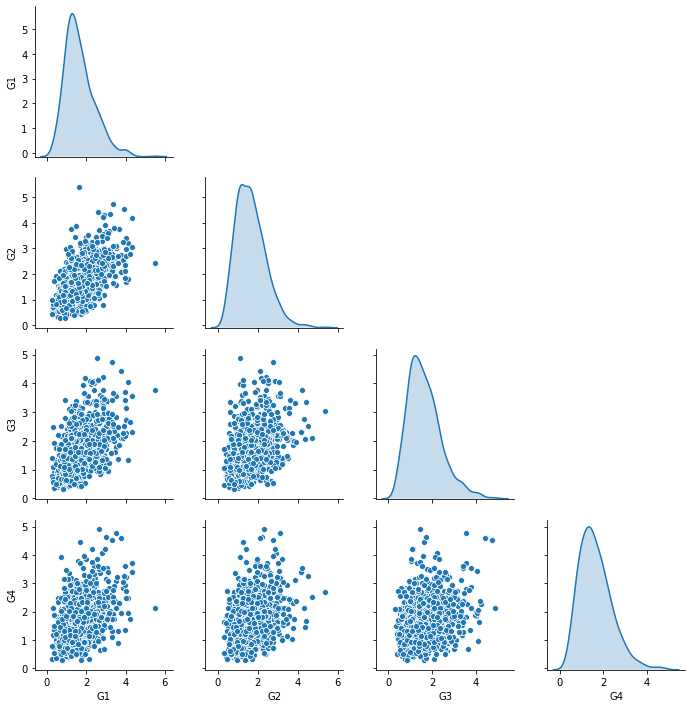

In [47]:
# Simulating from Gamma variates with rank-normal dependency
# Using a copula type method

import numpy as np
from scipy.stats import norm, gamma
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

# Fix number of variables and number simulations
N = 4
sims = 1000

# Fix means of normal variates
mu = np.ones(N)*0.5

# Initialize covariance matrix
cov = np.zeros((N, N))

# Select Gamma parameters a and b
a = 5
b = 3

# Create a covariance matrix
# Randomly sampled
for i in range(N):
    for j in range(N):
        if i==j:
            cov[i, j] = 1
        else:
            cov[i, j] = 0.5
            cov[j, i] = cov[i, j]

# Calculate cholesky decomposition
A = np.linalg.cholesky(cov)

# Sample independent normal variates
Z = norm.rvs(0,1, size=(sims, N))

# Convert to correlated normal variables
X = Z @ A + mu

# Standardize the normal variates
Z = (X - X.mean(axis=0)) / X.std(axis=0)

# Apply the normal CDF to create copula C
C = norm.cdf(Z)

# Use inverse transform to create Gamma variates
G = gamma.ppf(C, a=a, scale=1/b)

# Convert T to dataframe for plotting
dfg = pd.DataFrame(G, columns=["G1", "G2", "G3", "G4"])

# Create variable Plots
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)
    
pp = sns.pairplot(dfg, diag_kind="kde")
pp.map_upper(hide_current_axis)
plt.show()

This is really quite neat! It makes our modelling that much easier as we do not need to consider the joint-distribution in its entirety, we can break it down into smaller pieces that are easier to handle. The example above is quite a simple one however, we would like to have more freedom than this as we are still bound by sampling from a joint-distribution.

Let's look at some notation. Suppose we have variates: $(X_1, ... ,X_N)$ where each follows a cdf $F_i(x) = \mathbb{P}(X_i \leq x)$. We then have: $(U_1, ... , U_N) = (F_1(X_1), ..., F_N(X_N)$ with uniform random variates by definition. The copula defined by variables $(X_1, ..., X_N)$ is: $C(U_1, ... , U_N) = \mathbb{P}(X_1 \leq F_1(U_1), ... , X_N \leq F_N(U_N))$. From this definition $C: [0,1]^N \to [0,1]$ is an N-dimensional copula if it is a cumulative distribution function (CDF) on the unit cube with uniform marginals.

Going the other way any function $C: [0,1]^N \to [0,1]$ defines a copula if:
- $C(u_{1},\dots ,u_{i-1},0,u_{i+1},\dots ,u_{N})=0$, the copula is zero if any one of the arguments is zero,
- $C(1,\dots ,1,u,1,\dots ,1)=u$, the copula is equal to u if one argument is u and all others 1,
- C is d-non-decreasing, i.e., for each hyperrectangle $B=\prod _{i=1}^{N}[x_{i},y_{i}]\subseteq [0,1]^{N}$ the C-volume of B is non-negative:
$$\int _{B}\mathrm {d} C(u)=\sum _{\mathbf {z} \in \times _{i=1}^{N}\{x_{i},y_{i}\}}(-1)^{N(\mathbf {z} )}C(\mathbf {z} )\geq 0$$
where the $N(\mathbf {z} )=\#\{k:z_{k}=x_{k}\}$.

We now move onto the fundamental theorem of copulae: Sklar's theorem. The statement of the theorem exists in two parts:
1. Let $H(X_1, ..., X_N)$ represent a joint distribution function with marginal distributions $X_i \sim F_i$. Then there exists a copula $C(.)$ such that: $H(X_1, ..., X_N) = C(F_1(X_1), ... , F_N(X_N))$. Moreover if $F_i$ are continuous then the copula $C(.)$ is unique
2. Given a copula function $C(.)$ and univariate distribution functions $F_i$ then $C(F_1(X_1), ... , F_N(X_N))$ defines a joint distribution with marginal distributions $F_i$

Sklar's theorem shows there is a bijection relation between the space of joint distributions and the space of copulae (for continuous variables). This shows that this is indeed a powerful method to use in our modelling.

There are a couple of things to note here: the copula is itself a rank-order method of applying dependency. It is invariant under monotonic transforms (due to the use of the generalized inverse method). We can also derive the Fréchet–Hoeffding bounds:

$$ \operatorname{max}\left\{ 1 - N + \sum_{i=1}^{N} u_i, 0 \right\} \leq C(u_1, ..., u_N) \leq \operatorname{min} \{u_1, ... , u_N \}$$

We can see this quite easily by noting that for the lower-bound:
\begin{align}
C(u_1, ... , u_N) &= \mathbb{P} \left( \bigcap_{i=1}^N \{ U_i \leq u_i \} \right) \\
                  &= 1 - \mathbb{P} \left( \bigcup_{i=1}^N \{ U_i \geq u_i \} \right) \\
                  &\geq 1 - \sum_{i=1}^N \mathbb{P}( U_i \geq u_i ) \\
                  &= 1 - N + \sum_{i=1}^{N} u_i
\end{align}

For the upper bound we have:

$$ \bigcap_{i=1}^N \{ U_i \leq u_i \} \subseteq \{ U_i \leq u_i \} \qquad  \implies \qquad \mathbb{P} \left( \bigcap_{i=1}^N \{ U_i \leq u_i \} \right)  \leq \mathbb{P} \left(  U_i \leq u_i  \right) = u_i $$

For all possible indices $i$. We have that the upper-bound function $\operatorname{min} \{u_1, ... , u_N \}$ itself defines a copula corresponding to complete (rank) dependence. It is often called the "co-monotonic copula". The lower bound exists as a copula only in the case $N=2$ whereby it represents complete negative (rank) dependence.

We can also calculate the Spearman ($\rho$) and Kendall-Tau ($\tau$) dependency coefficients using the copula construction:

$$ \rho = 12 \int_0^1 \int_0^1 C(u,v) du dv - 3 $$

And:

$$ \tau = 4 \int_0^1 \int_0^1 C(u,v) dC(u,v) - 1$$

We can view the Gaussian example above in a copula frame via:

$$C^{Gauss}(u_1, ... , u_N) = \Phi_{\mathbf{\mu,\Sigma}}(\Phi^{-1}(u_1), ..., \Phi^{-1}(u_N))$$

Where: $\Phi_{\mathbf{\mu,\Sigma}}$ is the CDF of a multivariate Gaussian with means $\mathbf{\mu}$ and correlation matrix $\mathbf{\Sigma}$ The function: $\Phi^{-1}(.)$ is the inverse CDF of the univariate standard normal distribution. We call this the Gaussian copula or the rank-normal copula. 

We can define the student-t copula in a similar way. I have developed a model based around a hierarchical driver structure with a generalization of a student-t copula for the purposes of modelling insurance aggregation. You can read my blog-post dedicated to this specifically [here!](https://lewiscoleblog.com/insurance-aggregation-model)

But what are some other options? The copula methods are very flexible so lets look at some other examples. Starting off with the Archimedean family of copulae. A copula is Archimedian if it admits a representation:

$$ C_{Arch}(u_{1},\dots ,u_{N};\theta )=\psi ^{[-1]}\left(\psi (u_{1};\theta )+\cdots +\psi (u_{N};\theta );\theta \right) $$

Here the function $\psi$ is called the generator function. We also have parameter $\theta$ taking values in some arbitrary parameter space - the role that $\theta$ takes depends on the form of the generator. $\psi ^{-1}$ is the pseudo-inverse of $\psi$:

\begin{equation}
  \psi ^{[-1]}(t;\theta ) =
    \begin{cases}
      \psi ^{-1}(t;\theta )&{\mbox{if }}0\leq t\leq \psi (0;\theta ) \\
      0&{\mbox{if }}\psi (0;\theta )\leq t\leq \infty
    \end{cases}       
\end{equation}

We note that this functional form has some very useful properties. For example we note that we can express the upper and lower tail dependence parameters (defined above). If we place further assumptions on the generator function being a Laplace transform of strictly positive random variables we can write down neat forms of the upper and lower tail depdence metrics:

$$ \lambda _{u} = 2 - 2 \lim_{s \downarrow 0} \frac{\psi'^{[-1]} (2s)}{\psi'^{[-1]}  (s)} $$

and:
$$ \lambda _{l} = 2 \lim_{s \to \infty} \frac{\psi'^{[-1]} (2s)}{\psi'^{[-1]}  (s)} $$

Similarly we can conveniently calculate the Kendall-tau measure of dependence via:

$$ \tau = 1 + 4 \int_0^1 \frac{\psi(t)}{\psi'(t)} dt $$

This is very convenient for modelling purposes since we can easily control the joint properties in a predictable way. Unforunately the calculation of Spearman correlation coefficients is not as simple and in many cases a closed form analytic solution does not exist.

We can summarise some of the common Archimedean copulae in the table below:

|Copula Name     | $\psi(t)$ | $\psi^{[-1]}(t)$ | $\theta$-defined-range | Lower-Tail-$\lambda_l(\theta)$ | Upper-Tail-$\lambda_u(\theta)$ |$\tau$ |
|:--------|:------:|:-------------:|:----------------:|:-----------:|:-----------:|:-------:|
| Frank   | $-\log \left({\frac {\exp(-\theta t)-1}{\exp(-\theta )-1}}\right)$ | $-{\frac {1}{\theta }}\,\log(1+\exp(-t)(\exp(-\theta )-1))$ | $\mathbb {R} \backslash \{0\}$ | 0               | 0               | $1 + 4(D_1(\theta)-1)/\theta$ |
| Clayton | $\frac {1}{\theta }(t^{-\theta }-1)$ | $\left(1+\theta t\right)^{-1/\theta }$ | $[-1,\infty) \backslash \{0\}$                 | $2^{-1/\theta}$ | 0 | $\frac{\theta}{\theta + 2}$ |
| Gumbel  | $\left(-\log(t)\right)^{\theta }$     | $\exp\left(-t^{1/\theta }\right)$ | $[1, \infty)$ | 0 | $2-2^{1/\theta}$ | $1 - \theta^{-1}$  |

Where: $D_k(\alpha) = \frac{k}{\alpha^k} \int_0^{\alpha} \frac{t^k}{exp(t)-1} dt$ is the Debye function. 

We can see that the Frank copula applies dependence without any tail-dependence, whereas the Clayton and Gumbel are options for lower or upper-tail dependence modelling. This is in contrast to the student-t we observed before which applies symmetrically to both lower and upper tails.

To finish we will look at the bi-variate Frank, Clayton and Gumbel copulae. We will use a variety of methods to do this. For the Frank copula we will look at the "conditional" copula (that is the probability of one variate conditional on a specific value of the other): we will sample the overall percentile for the copula ($z$) and one of the variates ($u_1$) and then back "out" the remaining variate ($u_2$). The pair $\{ u_1, u_2\}$ is then distributed as the copula:

$$ u_2 = -\frac{1}{\theta} \log \left[1 + z\frac{1-e^{-\theta}}{z(e^{-\theta u}-1) - e^{-\theta u}} \right]$$

We can do the same for the Clayton:

$$ u_2 = \left(1 + u^{-\frac{1}{\theta}}  \left( z^{-\frac{1}{1+\theta}}-1 \right)  \right)^{-\theta}$$

Unforunately the conditinal copula of the Gumbel is not invertible and so we are unable to follow the same approach. Instead we follow the approach shown by Embrechts where we sample a uniform variate $v$ and then find $0<s<1$ such that: $sln(s) = \theta(s-v)$. We then sample another uniform variate $u$ and the pair: $\{ exp(u^{1/\theta}ln(s)), exp((1-u)^{1/\theta}ln(s))\}$ is a sample from the Gumbel copula with parameter $\theta$. 

We can implement this as:

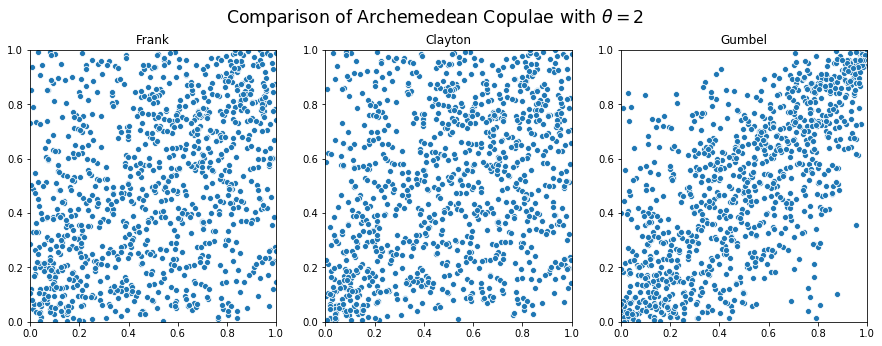

In [1]:
# Sampling from the Frank, Clayton and Gumbel archimedean Copulae
# A very basic bi-variate implementation

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import fsolve
%matplotlib inline

# Set number of simulations and theta parameter
sims = 1000
theta = 2

# Simulate u1 - first component of copula
U1 = np.random.random(sims)

# Simulate z - the joint probaibility
Z = np.random.random(sims)

# Define conversion functions for each copula
def frank(theta, z, u):
    return -1/theta*np.log(1+ z*(1-np.exp(-theta))/(z*(np.exp(-theta*u)-1) - (np.exp(-theta*u))))

def clayton(theta, z, u):
    return np.power((1+ np.power(u, -1/theta)*(np.power(z, -1/(1+theta))-1)), -theta)

# Define function to find S such that sln(s) = theta(s-u)
def gumfunc(s):
    return s*np.log(s) - theta*(s-U1)

# Use fsolve to find roots
S = fsolve(gumfunc, U1)

U1_gumbel = np.exp(np.log(S)*np.power(Z, 1/theta))
U2_gumbel = np.exp(np.log(S)*np.power(1-Z, 1/theta))

U1_frank = U1
U2_frank = frank(theta, Z, U1)

U1_clayton = U1
U2_clayton = clayton(theta, Z, U1)

# Create Plots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(U1_frank, U2_frank, ax=ax[0])
ax[0].set_title("Frank")
ax[0].set_xlim([0,1])
ax[0].set_ylim([0,1])
sns.scatterplot(U1_clayton, U2_clayton, ax=ax[1])
ax[1].set_title("Clayton")
ax[1].set_xlim([0,1])
ax[1].set_ylim([0,1])
sns.scatterplot(U1_gumbel, U2_gumbel, ax=ax[2])
ax[2].set_title("Gumbel")
ax[2].set_xlim([0,1])
ax[2].set_ylim([0,1])
fig.suptitle(r"Comparison of Archemedean Copulae with $\theta =$%i" %theta, x=0.5, y=1, size='xx-large')
plt.show()

As expected we can see little dependence in the tails of the Frank Copula, some dependence in the lower tail (small percentiles) of the Clayton and some dependence in the upper tail (larger percentiles) of the Gumbel copulae.

It was a bit of work to sample from these copulae. Thankfully packages exist to make our lives easier - for example: [copulas](https://pypi.org/project/copulas/). But is important to understand at least the basics behind how some of these packages work before we jump in and use them.

## Conclusion
We have now extended our abilities from being able to sample from univariate distributions in our previous blog post to how to sample from multi-variate distributions. We saw how we could use a Cholesky decomposition to sample from a mulit-variate normal and further how we could implement a driver approach in order to reduce the number of model parameters. We then saw how we could extend this to sample from a multi-variate student-t distribution. We then looked at copula methods in order to separate the marginal and joint behaviour of a system. We ended by looking at the powerful class of Archimedean copulae andthe Frank, Clayton and Gumbel copulae specifically.